In [1]:
import librosa
import numpy as np
import soundfile as sf
from scipy.signal import fftconvolve
from IPython.display import Audio

# Load original sweep (mono)
sweep, sr = librosa.load('Sine_sweep_single.wav', sr=None, mono=True)

# Load recorded response (stereo BRIR)
recorded, _ = librosa.load('Binaural_impulse.wav', sr=sr, mono=False)

# Generate time-reversed sweep
inverse_sweep = sweep[::-1]


In [2]:
# Convolve each channel of the recorded response with the inverse sweep
ir_left = fftconvolve(recorded[0], inverse_sweep, mode='full')
ir_right = fftconvolve(recorded[1], inverse_sweep, mode='full')

# Stack as stereo BRIR
brir = np.vstack((ir_left, ir_right))


In [3]:
# Normalize to prevent clipping
brir /= np.max(np.abs(brir))

# Save result
sf.write('deconvolved_brir.wav', brir.T, sr)


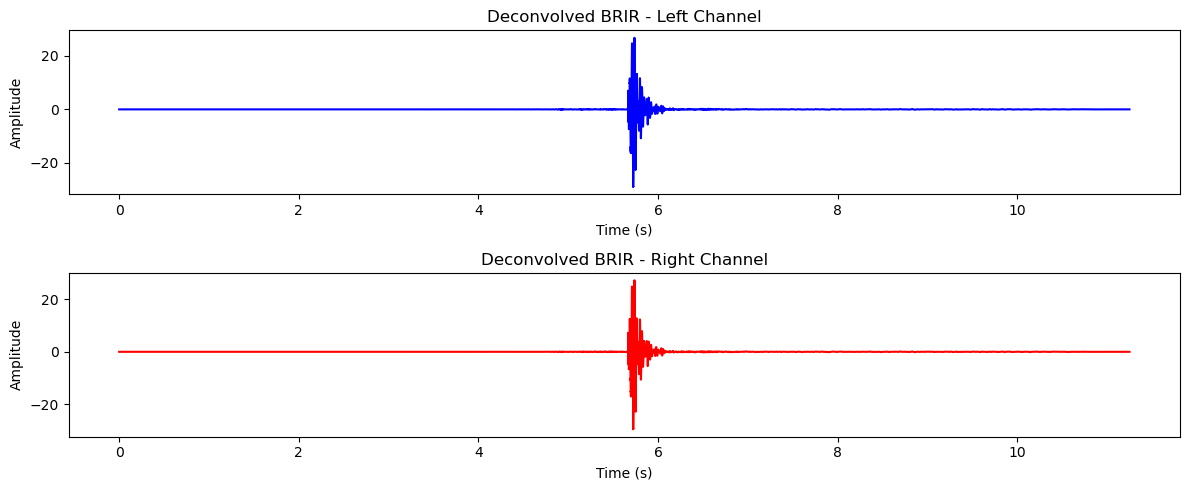

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Time axis (in seconds)
t = np.arange(len(ir_left)) / sr

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(t, ir_left, color='blue')
plt.title("Deconvolved BRIR - Left Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(t, ir_right, color='red')
plt.title("Deconvolved BRIR - Right Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


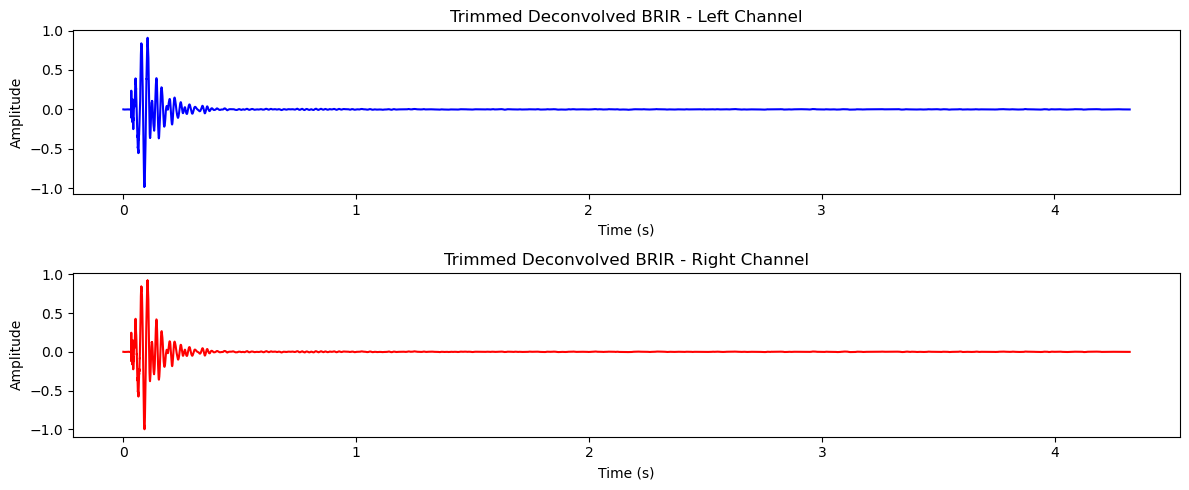

In [15]:


# Define a trim function based on a dB threshold
def trim_ir(ir, threshold_db= -60):
    threshold = 10 ** (threshold_db / 20)  # Convert dB to amplitude
    energy = np.abs(ir)
    last_idx = np.max(np.where(energy > threshold))  # Find the last significant sample
    return ir[:last_idx+1]

# Trim both channels (left and right)
brir_left_trimmed = trim_ir(brir[0], threshold_db=-60)
brir_right_trimmed = trim_ir(brir[1], threshold_db=-60)

# Time axis for trimmed BRIR (in seconds)
t_trimmed_left = np.arange(len(brir_left_trimmed)) / sr
t_trimmed_right = np.arange(len(brir_right_trimmed)) / sr

# Plot the trimmed BRIR
plt.figure(figsize=(12, 5))

# Plot Left Channel (trimmed)
plt.subplot(2, 1, 1)
plt.plot(t_trimmed_left, brir_left_trimmed, color='blue')
plt.title("Trimmed Deconvolved BRIR - Left Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Plot Right Channel (trimmed)
plt.subplot(2, 1, 2)
plt.plot(t_trimmed_right, brir_right_trimmed, color='red')
plt.title("Trimmed Deconvolved BRIR - Right Channel")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [11]:
# Load mono dry input audio
audio, sr = librosa.load('majula.wav', sr=None, mono=True)


# Make sure it's stereo
if brir.ndim != 2 or brir.shape[0] != 2:
    raise ValueError("BRIR must be stereo with shape (2, N)")

# Convolve input audio with BRIR
wet_left = fftconvolve(audio, brir[0], mode='full')
wet_right = fftconvolve(audio, brir[1], mode='full')

# Combine and normalize
wet = np.vstack((wet_left, wet_right))
##wet /= np.max(np.abs(wet))

# Save to file (optional)
sf.write('convolved_majula.wav', wet.T, sr)



In [12]:
Audio('convolved_majula.wav', rate=sr)
